<a href="https://colab.research.google.com/github/cubricmms/ProjectPneumonia/blob/ssd/Copy_of_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import csv
import random

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [3]:
!python -m pip install pydicom

     |████████████████████████████████| 35.3MB 82kB/s 


In [0]:
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize

In [5]:
!yes | python -m pip install -U tensorflow

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.9MB 36.8MB/s 
     |████████████████████████████████| 450kB 35.0MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
y


In [0]:
import tensorflow as tf
from tensorflow import keras

In [7]:

print(tf.__version__)

2.1.0


In [8]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6213009074615565288, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14764074232922751846
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3057759532050518711
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13015058237453238458
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [22]:
!ls "/content/gdrive/My Drive/rsna-pneumonia-detection-challenge"

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 stage_2_detailed_class_info.csv        stage_2_train_images
 stage_2_sample_submission.csv	        stage_2_train_labels.csv


# Load pneumonia images, bounding boxs and detail infos

csv file -- stage_2_train_labels.csv
* If a patient got diagnoised with multiple pneumonia, rows of bounding boxs of different pneumonia locations with same patientId will appear.
* If a patient has no pneumonia, csv contains a single row with nan for bounding boxs.

csv file -- stage_2_detailed_class_info.csv

* patientId with the final diagnoised varies between Normal, Lung Opacity, and No Lung Opacity / Not Normal.

In [0]:
dir_dicom = r"/content/gdrive/My Drive/rsna-pneumonia-detection-challenge"
dicoms_training = os.path.join(dir_dicom, 'stage_2_train_images')

In [0]:
df = pd.read_csv(os.path.join(dir_dicom, "stage_2_train_labels.csv")).fillna(0)
df_detail = pd.read_csv(os.path.join(dir_dicom, 'stage_2_detailed_class_info.csv'))

In [25]:
len(df), len(df_detail)

(30227, 30227)

In [26]:
df["patientId"].nunique()

26684

In [27]:
df.isna().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

### Patients got different numbers of pneumonia

In [28]:
df.groupby("patientId").size().reset_index(name="numbers_of_pneumonia").groupby("numbers_of_pneumonia").size()

numbers_of_pneumonia
1    23286
2     3266
3      119
4       13
dtype: int64

### Merge rows to one single row

In [0]:
columns = ['x', 'y', 'width', 'height']
df['bounding_boxs'] = df[columns].to_dict(orient='record')
df = df.drop(columns=columns)
df = df.groupby(["patientId", "Target"])["bounding_boxs"].apply(lambda df: df.reset_index(drop=True)).unstack().reset_index()

In [30]:
len(df)

26684

### append class of details of dataframe

In [31]:
_df = pd.merge(df, df_detail.drop_duplicates(), on=['patientId', 'patientId'])
_df

,patientId,Target,0,1,2,3,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal
1,000924cf-0f8d-42bd-9158-1af53881a557,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,Normal
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,"{'x': 316.0, 'y': 318.0, 'width': 170.0, 'heig...","{'x': 660.0, 'y': 375.0, 'width': 146.0, 'heig...",NaN,NaN,Lung Opacity
3,000fe35a-2649-43d4-b027-e67796d412e0,1,"{'x': 570.0, 'y': 282.0, 'width': 269.0, 'heig...","{'x': 83.0, 'y': 227.0, 'width': 296.0, 'heigh...",NaN,NaN,Lung Opacity
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1,"{'x': 66.0, 'y': 160.0, 'width': 373.0, 'heigh...","{'x': 552.0, 'y': 164.0, 'width': 376.0, 'heig...",NaN,NaN,Lung Opacity
...,...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,1,"{'x': 177.0, 'y': 285.0, 'width': 225.0, 'heig...","{'x': 641.0, 'y': 473.0, 'width': 201.0, 'heig...",NaN,NaN,Lung Opacity
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,Normal
26681,fffc95b5-605b-4226-80ab-62caec682b22,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal
26682,fffcff11-d018-4414-971a-a7cefa327795,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal


In [32]:
len(_df)

26684

In [0]:
def print_bounding_box(df, nc = 9):
    """plot rectangle boxs for a single dicom image
    params: patientId and bounding boxs       
    """
    plot_width = 3
    plot_height = nc // plot_width + 1 if nc % plot_width else nc // plot_width
    # Create figure and axes
    fig, ax = plt.subplots(plot_height, plot_width, figsize=(16,18))

    i = 0
    for idx, dicom in df.iterrows():
        _dicom_path = os.path.join(dicoms_training, dicom['patientId'] + '.dcm')
        _dicom_img = pydicom.dcmread(_dicom_path)


        # Display the image
        ax[i//3, i%3].imshow(_dicom_img.pixel_array, cmap=plt.cm.bone)#cmap stands for color map
        ax[i//3, i%3].axis('off')
        for bb in (dicom[0], dicom[1], dicom[2], dicom[3]):
            if isinstance(bb, dict) and bb["x"] != "nan":
                x = bb["x"]
                y = bb["y"]
                w = bb["width"]
                h = bb["height"] 
                # Create a Rectangle patch
                rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')

                # Add the patch to the Axes
                ax[i//3, i%3].add_patch(rect)
        
            ax[i//3, i%3].set_title('ID: {}\nAge: {} Sex: {} Target: {}\nClass: {}'.format(
                dicom['patientId'],
                _dicom_img.PatientAge, 
                _dicom_img.PatientSex, 
                dicom['Target'], 
                dicom['class']))
        
        i += 1
        
        if i >= nc:
            break
    plt.show()

## Get some samples of bb(bounding boxs) of 1, 2, 3, 4

In [0]:
df_4 = _df[_df[3].notna()] # Patients with 4 bounding boxs
df_3 = _df[_df[2].notna()]
df_2 = _df[_df[1].notna()]
df_1 = _df[_df[0].notna()]
df_0 = _df[_df[0] == dict(x=0, y=0, width=0, height=0)]

df_3 = df_3[~df_3.patientId.isin(df_4.patientId)]
df_2 = df_2[~df_2.patientId.isin(df_3.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_2.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_0.patientId)]

# Photometric Interpretation          CS: 'MONOCHROME2',
# Rows                                US: 1024,
# Columns                             US: 1024,

In [35]:
df_4.head(9)

,patientId,Target,0,1,2,3,class
826,0ab261f9-4eb5-42ab-a9a5-e918904d6356,1,"{'x': 613.0, 'y': 352.0, 'width': 106.0, 'heig...","{'x': 266.0, 'y': 644.0, 'width': 135.0, 'heig...","{'x': 545.0, 'y': 452.0, 'width': 215.0, 'heig...","{'x': 722.0, 'y': 558.0, 'width': 88.0, 'heigh...",Lung Opacity
1103,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,1,"{'x': 342.0, 'y': 157.0, 'width': 148.0, 'heig...","{'x': 633.0, 'y': 128.0, 'width': 90.0, 'heigh...","{'x': 655.0, 'y': 478.0, 'width': 163.0, 'heig...","{'x': 214.0, 'y': 374.0, 'width': 193.0, 'heig...",Lung Opacity
1128,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,1,"{'x': 654.0, 'y': 444.0, 'width': 160.0, 'heig...","{'x': 531.0, 'y': 206.0, 'width': 289.0, 'heig...","{'x': 686.0, 'y': 545.0, 'width': 128.0, 'heig...","{'x': 213.0, 'y': 386.0, 'width': 114.0, 'heig...",Lung Opacity
2041,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,1,"{'x': 322.0, 'y': 327.0, 'width': 116.0, 'heig...","{'x': 340.0, 'y': 564.0, 'width': 108.0, 'heig...","{'x': 631.0, 'y': 339.0, 'width': 102.0, 'heig...","{'x': 631.0, 'y': 474.0, 'width': 129.0, 'heig...",Lung Opacity
2052,1c44e0a4-4612-438f-9a83-8d5bf919cb67,1,"{'x': 658.0, 'y': 346.0, 'width': 145.0, 'heig...","{'x': 258.0, 'y': 786.0, 'width': 157.0, 'heig...","{'x': 315.0, 'y': 363.0, 'width': 126.0, 'heig...","{'x': 667.0, 'y': 683.0, 'width': 226.0, 'heig...",Lung Opacity
2914,31764d54-ea3b-434f-bae2-8c579ed13799,1,"{'x': 258.0, 'y': 521.0, 'width': 266.0, 'heig...","{'x': 293.0, 'y': 311.0, 'width': 166.0, 'heig...","{'x': 713.0, 'y': 593.0, 'width': 181.0, 'heig...","{'x': 649.0, 'y': 319.0, 'width': 190.0, 'heig...",Lung Opacity
3003,3239951b-6211-4290-b237-3d9ad17176db,1,"{'x': 511.0, 'y': 249.0, 'width': 188.0, 'heig...","{'x': 558.0, 'y': 649.0, 'width': 174.0, 'heig...","{'x': 152.0, 'y': 661.0, 'width': 191.0, 'heig...","{'x': 198.0, 'y': 370.0, 'width': 204.0, 'heig...",Lung Opacity
3007,32408669-c137-4e8d-bd62-fe8345b40e73,1,"{'x': 273.0, 'y': 856.0, 'width': 234.0, 'heig...","{'x': 702.0, 'y': 801.0, 'width': 249.0, 'heig...","{'x': 300.0, 'y': 367.0, 'width': 226.0, 'heig...","{'x': 706.0, 'y': 360.0, 'width': 232.0, 'heig...",Lung Opacity
3282,349f10b4-dc3e-4f3f-b2e4-a5b81448ce87,1,"{'x': 365.0, 'y': 192.0, 'width': 115.0, 'heig...","{'x': 614.0, 'y': 264.0, 'width': 128.0, 'heig...","{'x': 594.0, 'y': 465.0, 'width': 259.0, 'heig...","{'x': 204.0, 'y': 385.0, 'width': 219.0, 'heig...",Lung Opacity


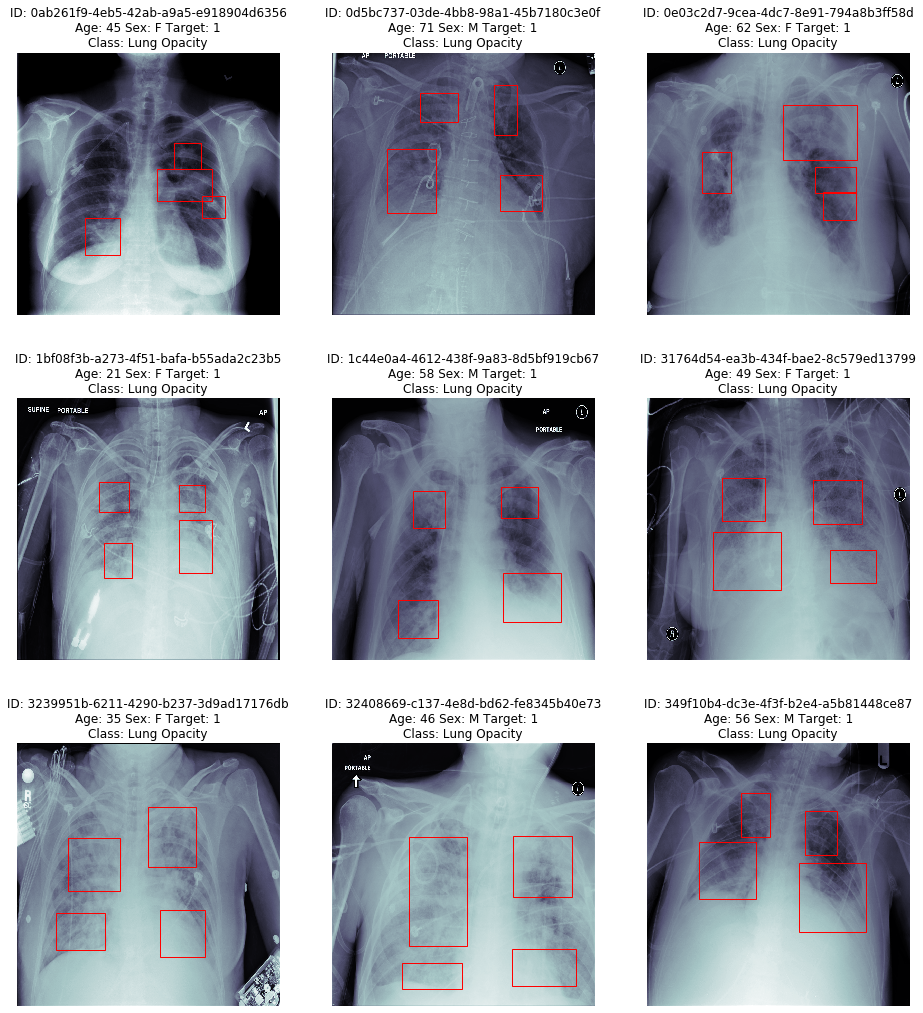

In [36]:
print_bounding_box(df_4)

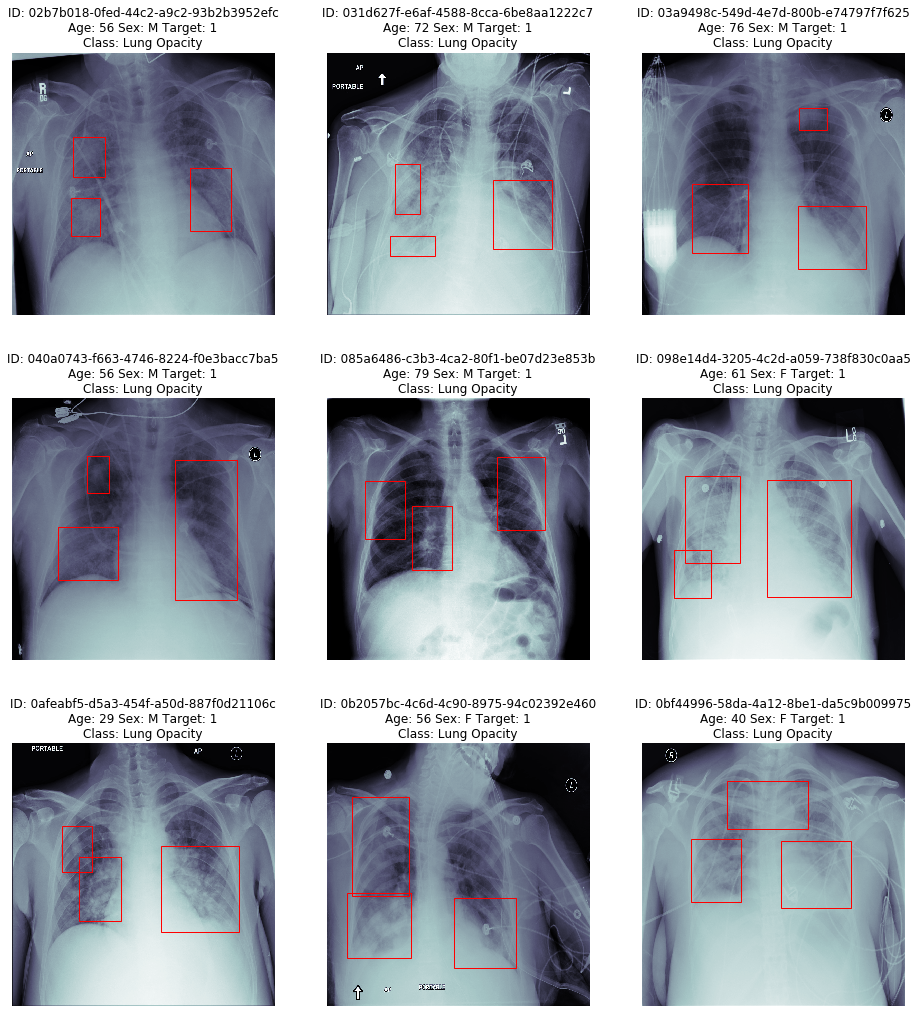

In [37]:
print_bounding_box(df_3)

26684 patients


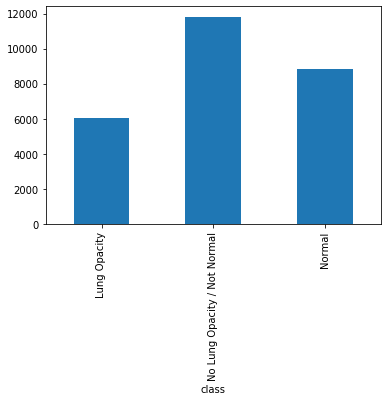

In [38]:
print(_df['patientId'].value_counts().shape[0], 'patients')
_df.groupby('class').size().plot.bar()

#### It clearly shows patients with lung opacity is our target

In [39]:
_df.groupby(["class", "Target"]).size()

class                         Target
Lung Opacity                  1          6012
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
dtype: int64

## load dicom image specification into dataframe _df

In [0]:
for idx, dicom in _df.iterrows():
    _dicom_path = os.path.join(dicoms_training, dicom['patientId'] + '.dcm')
    _dicom_img = pydicom.dcmread(_dicom_path)
    
    _df.loc[idx,'Modality'] = _dicom_img.Modality
    _df.loc[idx,'PatientAge'] = pd.to_numeric(_dicom_img.PatientAge)
    _df.loc[idx,'PatientSex'] = _dicom_img.PatientSex
    _df.loc[idx,'BodyPartExamined'] = _dicom_img.BodyPartExamined
    _df.loc[idx,'ViewPosition'] = _dicom_img.ViewPosition
    _df.loc[idx,'ConversionType'] = _dicom_img.ConversionType
    _df.loc[idx,'Rows'] = _dicom_img.Rows
    _df.loc[idx,'Columns'] = _dicom_img.Columns  
    _df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",_dicom_img.PixelSpacing[0]) 

_df.to_pickle(os.path.join(os.getcwd(), "df_save.pkl"))

In [0]:
_df = pd.read_pickle(os.path.join(os.getcwd(), "df_save.pkl"))